# SOLUTION Advanced ML Week 3, Lecture 1: Text Vectorization - Sequences

In [1]:
from IPython.display import display, Markdown
with open("../Data-AmazonReviews/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [2]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# MacOS Sonoma Fix
tf.config.set_visible_devices([], 'GPU')

In [3]:
import pandas as pd 
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)



In [4]:
import joblib
df = joblib.load('../Data-AmazonReviews/processed_data.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8191 entries, 0 to 8256
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   overall            8191 non-null   float64
 1   text-raw           8191 non-null   object 
 2   length             8191 non-null   int64  
 3   text               8191 non-null   object 
 4   lower_text         8191 non-null   object 
 5   tokens             8191 non-null   object 
 6   no_stops           8191 non-null   object 
 7   no_stops_no_punct  8191 non-null   object 
 8   spacy_lemmas       8191 non-null   object 
 9   bigrams            8191 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 703.9+ KB


,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
0,4.0,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,672,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,not going to show you the dirty water on here because i have shame and it ...: used it twice already and i have absolutely seen results. not going to show you the dirty water on here because i have shame and it is gross. i will say that while you...,"[not, going, to, show, you, the, dirty, water, on, here, because, i, have, shame, and, it, ..., :, used, it, twice, already, and, i, have, absolutely, seen, results, ., not, going, to, show, you, the, dirty, water, on, here, because, i, have, sha...","[going, show, dirty, water, shame, ..., :, used, twice, already, absolutely, seen, results, ., going, show, dirty, water, shame, gross, ., say, 're, cleaning, ,, leave, place, second, (, instance, ,, 're, moving, plug, new, outlet, ), ,, leak, li...","[going, show, dirty, water, shame, ..., used, twice, already, absolutely, seen, results, going, show, dirty, water, shame, gross, say, 're, cleaning, leave, place, second, instance, 're, moving, plug, new, outlet, leak, little, water, part, sucks...","[go, dirty, water, shame, twice, absolutely, see, result, go, dirty, water, shame, gross, clean, leave, place, second, instance, move, plug, new, outlet, leak, little, water, suck, upward, big, deal, suck, right, happen, end, cleaning, remove, ta...","[(go, dirty), (dirty, water), (water, shame), (shame, twice), (twice, absolutely), (absolutely, see), (see, result), (result, go), (go, dirty), (dirty, water), (water, shame), (shame, gross), (gross, clean), (clean, leave), (leave, place), (place..."
1,5.0,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,1021,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,makes carpet look brand new!!!: when you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n my carpets were very dirty because i have 2 small dogs that go in and hour all d...,"[makes, carpet, look, brand, new, !, !, !, :, when, you, get, the, shampooer, you, have, to, put, it, together, but, is, very, easy, ..., the, handle, is, the, only, thing, that, you, have, to, attach, ..., my, carpets, were, very, dirty, because...","[makes, carpet, look, brand, new, !, !, !, :, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, ., w...","[makes, carpet, look, brand, new, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, week, later, dow...","[make, carpet, look, brand, new, shampooer, easy, handle, thing, attach, carpet, dirty, 2, small, dog, hour, day, 1st, day, get, shampoo, shampoo, entire, house, huge, difference, week, later, downstair, dirt, carpet, shampoo, carpet, look, brian...","[(make, carpet), (carpet, look), (look, brand), (brand, new), (new, shampooer), (shampooer, easy), (easy, handle),

In [5]:
def create_groups(x):
    if x>=5.0:
        return "high"
    elif x <=2.0:
        return "low"
    else: 
        return None
    

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

In [6]:
## Use the function to create a new "rating" column with groups
df['rating'] = df['overall'].map(create_groups)
df['rating'].value_counts(dropna=False)

high    5547
None    1832
low      812
Name: rating, dtype: int64

In [7]:
## Check class balance of 'rating'
df['rating'].value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

In [8]:
# Create a df_ml without null ratings
df_ml = df.dropna(subset=['rating']).copy()
df_ml.isna().sum()

overall              0
text-raw             0
length               0
text                 0
lower_text           0
tokens               0
no_stops             0
no_stops_no_punct    0
spacy_lemmas         0
bigrams              0
rating               0
dtype: int64

In [9]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df_ml['text']

# y - use our binary target 
y = df_ml['rating']
X.head(10)

1     Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...
4     VERY DISAPPOINTED: WORKED for maybe 1/2 hr and then it appeared the motor got hot and shut off and 10 secs later would start again and would work for 10 or 15 secs and quit again.......sending it back to HOOVER this week......I was VERY DISAPPOIN...
5                                                                 Perfect!: I love this cleaner!  It's easy to operate, light enough to manipulate and easy to clean. The tank holds plenty of shampoo and water solution and the suction for removal is great.
6     Wow - way exceeded expectations: I had the older model from probably 2001 and it was great for the occasional pet stain or the muddy paw prints on white carpet situation, but it was not for routine cleaning.  It finally konked

In [10]:
y.value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

## Train-Test-Split Version

In [11]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
len(X_train_full), len(X_test)

(4451, 1908)

### Using Sklearn's LabelEncoder

In [12]:
y_train_full[:10]

3889    high
3254    high
2996    high
3790    high
3764    high
7301    high
2449    high
430     high
2296    high
2321     low
Name: rating, dtype: object

In [13]:
encoder = LabelEncoder()
y_train_full_enc = encoder.fit_transform(y_train_full.values)
y_test_enc = encoder.transform(y_test)

y_train_full_enc[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [14]:
# Original Class names saved as .classes_
classes = encoder.classes_
classes

array(['high', 'low'], dtype=object)

In [15]:
# Can inverse-transform 
encoder.inverse_transform([0,1])

array(['high', 'low'], dtype=object)

In [16]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

In [17]:
try:
    X_train, y_train = sampler.fit_resample(X_train_full,y_train_full_enc)
except Exception as e:
    display(e)

ValueError('Expected 2D array, got 1D array instead:\narray=[\'Really like it!: Love this!  No more pulling out the vacuum cleaner from the garage and plugging it in 3 different places to get the whole room.  Suction is great, very compact and nice handling.  We will see if it holds up.  I did buy the extended warranty for 6 bucks due to some of the reviews.  But if I had to spend 100 on a new one every year I would.\'\n \'which is awesome.: My last carpet cleaner broke so I bought this one after reading the reviews. It cleans very well! My carpet dries in about 30 minutes, which is awesome.\'\n \'seriously powerful: This is our second of these vacuums- we liked the first so much that we decided to get a second one for the second floor of our house.  This is the only "stick vac" we have found that can compete with our Dyson. We have four cats, three birds, and a ten year old daughter with very long hair, plus a garden we track leaves and dirt in from, so we\\\'re constantly (and I do m

In [18]:
# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train_enc = sampler.fit_resample(X_train_full.values.reshape(-1,1),
                                        y_train_full_enc)
X_train.shape

(1118, 1)

In [19]:
# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()
X_train.shape

(1118,)

### Previous ML Model

In [20]:
# Adding parent directory to python path
import sys, os
sys.path.append( os.path.abspath('../'))

In [21]:
## Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import custom_functions_SOLUTION  as fn

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       559
           1       0.99      0.95      0.97       559

    accuracy                           0.97      1118
   macro avg       0.97      0.97      0.97      1118
weighted avg       0.97      0.97      0.97      1118



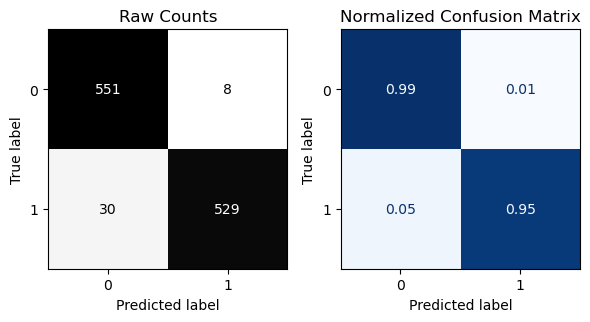


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1655
           1       0.68      0.91      0.78       253

    accuracy                           0.93      1908
   macro avg       0.83      0.92      0.87      1908
weighted avg       0.94      0.93      0.94      1908



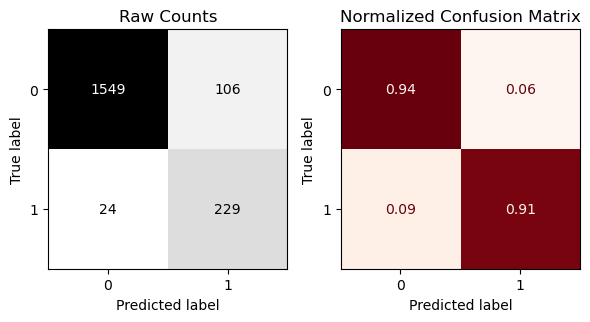

In [23]:
## Create a model pipeline 
count_pipe = Pipeline([('vectorizer',  CountVectorizer()), 
                       ('naivebayes',  MultinomialNB())])

count_pipe.fit(X_train, y_train_enc)
fn.evaluate_classification(count_pipe, X_train, y_train_enc, X_test, y_test_enc,)

## Preparing For Neural Networks (Train-Test-Val Datasets)

In [24]:
# Check for class balance
pd.Series(y_train_enc).value_counts()

0    559
1    559
dtype: int64

### Prepare Tensorflow Datasets

Since we already have train/test/val X and y vars, we will make 3 dataset objects using tf.data.Dataset.from_tensor_slices.

In [25]:
# Convert to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
# Shuffle dataset
train_ds = train_ds.shuffle(buffer_size=len(train_ds),
                            reshuffle_each_iteration=False)

Split the val/test data in 2 

In [26]:
# Convert test to dataset object and split
val_test_split_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
val_test_split_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [27]:
len(X_test)/2

954.0

In [28]:
n_val_samples =  int(len(val_test_split_ds) * .5)
n_val_samples

954

In [29]:
## Perform the val/test split

## Create the validation dataset
val_ds = val_test_split_ds.take(n_val_samples)

## Create the test dataset
test_ds = val_test_split_ds.skip(n_val_samples)

In [30]:
len(train_ds), len(val_ds), len(test_ds)

(1118, 954, 954)

Let's examine a single element.

In [31]:
# taking a sample 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'Easy, Fast and does a Good Job: Easy to use, fast set-up.  It did a great job on the carpet I wanted to rescue.', shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


In [32]:
# taking a sample  (same result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'Easy, Fast and does a Good Job: Easy to use, fast set-up.  It did a great job on the carpet I wanted to rescue.', shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


> Shuffle the training data at the end of each epoch

In [33]:
# Shuffle only the training data every epoch
train_ds = train_ds.shuffle(len(train_ds))

In [34]:
# taking a sample  (different result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"I want it to have a good hand tool for washing the carpeted staircase: I don't nee much from a carpet washer. I want it to have a good hand tool for washing the carpeted staircase, and a dirty tank that can be cleaned. My old Bissel had a tank that got packed with fibers that were not even theoretically removable. This tank I can disassemble, wash, dry, and assemble back. Thank you.", shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


In [35]:
# taking a sample  (different result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'Hoover SteamVac f5914-900 beat my old rainbow hands down: This steamvac made our carpets look like new, we were thinking of replacing them but now we do not have too.  Works well above what I ever thought it could.  Love it and I used to hate cleaning the carpet with the old rainbow.', shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


> Add batching (use 32 for batch_size)

In [36]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 35 training batches.
 There are 30 validation batches.
 There are 30 testing batches.


In [37]:
# taking a sample - now 32 observations instead of 1
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)


tf.Tensor(
[b'Two Stars: cumbersome'
 b"Excellent cleaning machine. Keeps my carpets clean for our newborn. Worked great getting rid of tough pet stains too.: I had the Bissell portable unit before this. That one broke, so I gave this a try.\n\nIt is light years ahead of the Bissell, but it costs more so you might expect it to be. I only wish I had bought this first. The additional vacuum-driven cleaning brush is a major bonus too. It's so much easier to spot clean now.\n\nWe just had a baby and I want to keep all our carpets very clean. Before he was born, I used it to clean up our cat's accidents. It does a great job spot cleaning and cleaning large areas. It works as well if not better than the rental ones ... and you don't have to worry about other people's gunk.\n\nThe separate water / detergent chambers make it easy to keep it filled with detergent and not waste any. I just refill the water reservoir with hot water and I'm ready to clean!"
 b'So thrilled with the way it cleans.: 

# Vectorizing Text with Keras's TextVectorization Layer

> ADD INTRO, explain need for sequence length

In [38]:
# df_ml['length (characters)'] = df_ml['text'].map(len)
# df_ml.head(3)

# ax = sns.histplot(data=df_ml, hue='rating', x='length (characters)',
#                 stat='percent',common_norm=False)#, estimator='median',);
# ax.axvline()

## Text Vectorization Layer

### Determine appropriate sequence length. 

In [39]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df_ml['length (tokens)'] = df_ml['text'].map( lambda x: len(x.split(" ")))
df_ml['length (tokens)'].describe()

count    6359.000000
mean       85.317345
std       105.261462
min         2.000000
25%        21.000000
50%        52.000000
75%       106.000000
max      1521.000000
Name: length (tokens), dtype: float64

In [40]:
# ax = sns.histplot(data=df_ml, hue='rating', x='length (tokens)',
#                 stat='frequency',common_norm=False)#, estimator='median',);


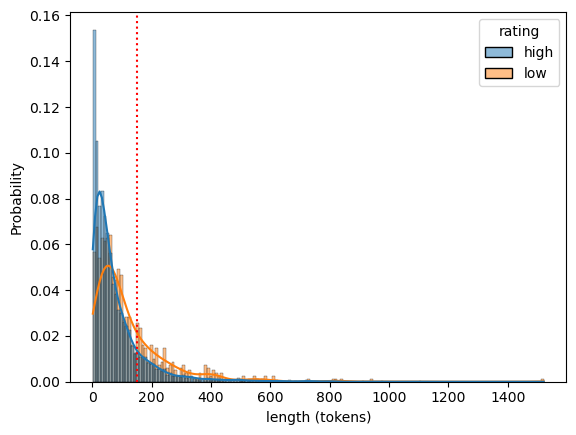

In [41]:
SEQUENCE_LENGTH = 150
ax = sns.histplot(data=df_ml, hue='rating', x='length (tokens)',kde=True,
                stat='probability',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")

### Create the Training Texts Dataset

> We need to get a version of our data that is **only the texts**.

In [42]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()

2024-01-04 22:02:54.689395: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"If you have kids or animals or both - you need this.: I usually rent a rug doctor to clean my carpets but I just got tired of that and started to let them go to long so I bought this to keep in the house.  I love it, should have done this years ago when the kids were younger.\nPros:\nEasy to use, not any harder then pushing your vacume around.\nDoes a very nice job\nPrice is good, same as walmart\n\nCon:\nTank is a little small so you have to fill and empty often.  But since I'm not renting it by the hour it's not that big of a deal for me.",
       b"Leaked everywhere, but I got my money back on it: Bought it Nov. 2016.  It's broken a year later.  I bought the 2-year warranty provided by Square Trade, who issued me a full refund, sending me a refund check in the mail and did NOT ask for the machine back.  The machine leaked a bit from the first time I used it, a reported issue in the reviews.  But, I so loved the machine that I pu

### Instantiate a TextVectorization Layer

Flexible layer that can convert text to bag-of-words or sequences.

In [43]:
# # Create text Vectorization layer
# count_vectorizer = tf.keras.layers.TextVectorization(
#     standardize="lower_and_strip_punctuation",
#     output_mode="count",
#     # output_sequence_length=SEQUENCE_LENGTH
# )
# count_vectorizer

In [44]:
# # Before training, only contains the out of vocab token ([UNK])
# count_vectorizer.get_vocabulary()

In [45]:
example_text = [['Sometimes I love this vacuum, sometimes i hate this vacuum']]

In [46]:
# # Fitting the vectorizer using .adapt
# count_vectorizer.adapt(example_text)

# # Before training, only contains the out of vocab token ([UNK])
# count_vectorizer.get_vocabulary()#[:10]

In [47]:
# counts = count_vectorizer(example_text)
# print(counts)

In [48]:
# Create text Vectorization layer
demo_sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=50
)

In [49]:
# Fitting the vectorizer using .adapt
demo_sequence_vectorizer.adapt(example_text)
# Before training, only contains the out of vocab token ([UNK])
demo_sequence_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'vacuum', 'this', 'sometimes', 'i', 'love', 'hate']

In [50]:
# Before training, only contains the out of vocab token ([UNK])
demo_sequence_vectorizer.get_vocabulary()

['', '[UNK]', 'vacuum', 'this', 'sometimes', 'i', 'love', 'hate']

In [51]:
sequences = demo_sequence_vectorizer(example_text)
print(sequences)

tf.Tensor(
[[4 5 6 3 2 4 5 7 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 50), dtype=int64)


In [52]:
# # Fit the layer on the training texts
# try:
#     sequence_vectorizer.adapt(train_ds)
# except Exception as e:
#     display(e)

### "Fitting" the Text Vectorization Layer

In [53]:
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [54]:
# Fitting the vectorizer using .adapt
sequence_vectorizer.adapt(ds_texts)

In [55]:
# Before training, only contains the out of vocab token ([UNK])
sequence_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'it', 'and', 'to', 'a', 'this', 'is']

In [56]:
# Saving the Size of the Vocab
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

5889

In [57]:
# # Getting list of vocab
# vocab = sequence_vectorizer.get_vocabulary()
# int_to_str = {idx: word for idx, word in enumerate(vocab)}
# int_to_str



### Simple RNN

In [58]:
sequence_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': None,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 150,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 5889}

In [59]:
sequence_vectorizer.get_config()['output_sequence_length']

150

In [60]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 50, 200)           1177800   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                7456      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,185,289
Trainable params: 1,185,289
Non-trainable params: 0
______________________________________________

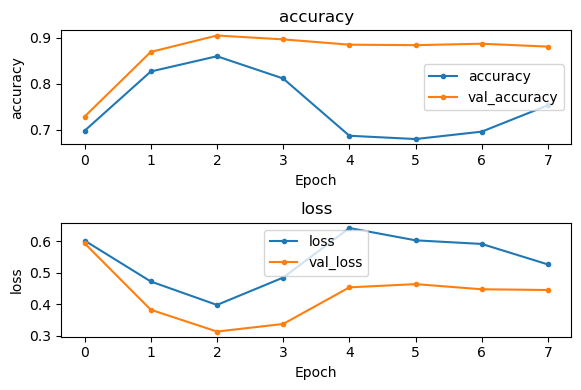

In [61]:
### BEST


def build_rnn_model(text_vectorization_layer):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.SimpleRNN(32)) #BEST=32
    model.add(layers.Dropout(.3)) #BEST=.3
    
    # Add output layer
    # model.add(layers.Dense(len(classes), activation='softmax'))
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',#'sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model

def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

## Create text Vectorization layer
SEQUENCE_LENGTH=50 #BEST=50
EMBED_DIM = 200 # BEST= 200

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(ds_texts)

# Build the lstm model and specify the vectorizer
rnn_model = build_rnn_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5),
)
fn.plot_history(history,figsize=(6,4))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       559
           1       0.93      0.58      0.71       559

    accuracy                           0.77      1118
   macro avg       0.81      0.77      0.76      1118
weighted avg       0.81      0.77      0.76      1118



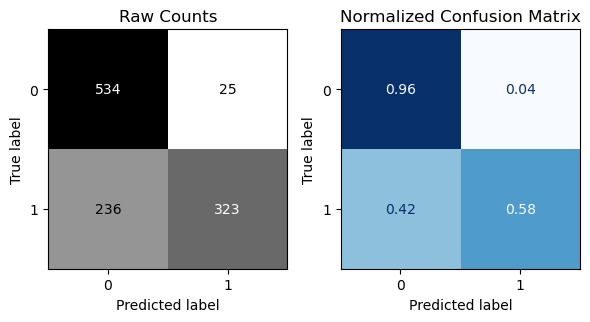


- Evaluating Training Data:
35/35 [==============================] - 0s 2ms/step - loss: 0.4598 - accuracy: 0.7665
{'loss': 0.4598497748374939, 'accuracy': 0.7665473818778992}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       833
           1       0.55      0.36      0.44       121

    accuracy                           0.88       954
   macro avg       0.73      0.66      0.69       954
weighted avg       0.87      0.88      0.87       954



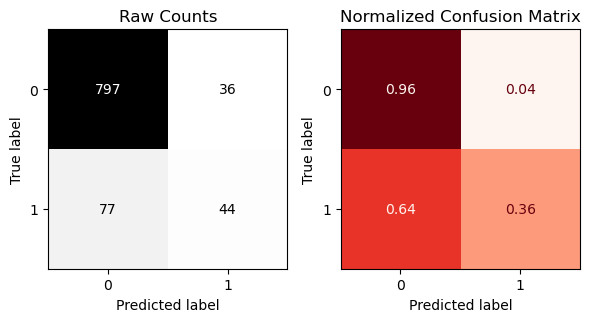


- Evaluating Test Data:
30/30 [==============================] - 0s 2ms/step - loss: 0.4490 - accuracy: 0.8816
{'loss': 0.4489750266075134, 'accuracy': 0.8815513849258423}


In [62]:
# Obtain the results
results = fn.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

### Experimental Version

In [ ]:
### BEST


def build_rnn_model(text_vectorization_layer):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.SimpleRNN(32)) #BEST=32
    model.add(layers.Dropout(.3)) #BEST=.3
    
    # Add output layer
    # model.add(layers.Dense(len(classes), activation='softmax'))
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',#'sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model

def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

## Create text Vectorization layer
SEQUENCE_LENGTH=50 #BEST=50
EMBED_DIM = 200 # BEST= 200

exp_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

exp_vectorizer.adapt(ds_texts)

# Build the lstm model and specify the vectorizer
exp_rnn_model = build_rnn_model(exp_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
exp_history = exp_rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5),
)
fn.plot_history(exp_history,figsize=(6,4))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 50, 200)           1177800   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                7456      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,185,289
Trainable params: 1,185,289
Non-trainable params: 0
____________________________________________

In [ ]:
# Obtain the results
results = fn.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds, #history=history
);

### LSTM

In [ ]:
# # Define a function for building an LSTM model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers, optimizers, regularizers
# def build_lstm_model(text_vectorization_layer):
    
#     # Define sequential model with pre-trained vectorization layer and *new* embedding layer
#     lstm_model = Sequential([
#         text_vectorization_layer,
#         layers.Embedding(input_dim=VOCAB_SIZE,
#                                   output_dim=EMBED_DIM, 
#                                   input_length=SEQUENCE_LENGTH)
#         ])
        
#     # Add *new* LSTM layer
#     lstm_model.add(layers.LSTM(128))
#     # Add output layer
#     lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
#     # Compile the model
#     lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
#                   loss='sparse_categorical_crossentropy', 
#                   metrics=['accuracy'])
    
#     lstm_model.summary()
#     return lstm_model

# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
#     return [early_stop]



In [ ]:
# Create text Vectorization layer
SEQUENCE_LENGTH = 100
EMBED_DIM = 100

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(ds_texts)


In [ ]:
VOCAB_SIZE

In [ ]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

# APPENDIX

## 🚧Functions (To Move to .py file) {move to before ML}

In [ ]:
# from pprint import pprint
# def make_text_vectorization_layer(train_ds,  max_tokens=None, 
#                                   split='whitespace',
#                                   standardize="lower_and_strip_punctuation",
#                                   output_mode="int",
#                                   output_sequence_length=None,
#                                   ngrams=None, pad_to_max_tokens=False,
#                                   verbose=True,
#                                   **kwargs,
#                                  ):
#     # Build the text vectorization layer
#     text_vectorizer = tf.keras.layers.TextVectorization(
#         max_tokens=max_tokens,
#         standardize=standardize, 
#         output_mode=output_mode,
#         output_sequence_length=output_sequence_length,
#         **kwargs
#     )
#     # Get just the text from the training data
#     if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
#         ds_texts = train_ds
#     else:
#         try:
#             ds_texts = train_ds.map(lambda x, y: x )
#         except:
#             ds_texts = train_ds
            
#     # Fit the layer on the training texts
#     text_vectorizer.adapt(ds_texts)
    
    
#     if verbose:
#         # Print the params
#         print( "\ntf.keras.layers.TextVectorization(" )
#         config = text_vectorizer.get_config()
#         pprint(config,indent=4)
#         print(")")
               
#     # SAVING VOCAB FOR LATER
#     # Getting list of vocab 
#     vocab = text_vectorizer.get_vocabulary()
#     # Save dictionaries to look up words from ints 
#     int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
#     return text_vectorizer, int_to_str


In [ ]:
# # Writing a demo custom function for .py file
# def demo_function(name):
#     print(f'Hello, {name}!')



In [ ]:
# from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# def classification_metrics(y_true, y_pred, label='',
#                            output_dict=False, figsize=(8,4),
#                            normalize='true', cmap='Blues',
#                            colorbar=False,values_format=".2f"):
#     """Modified version of classification metrics function from Intro to Machine Learning.
#     Updates:
#     - Reversed raw counts confusion matrix cmap  (so darker==more).
#     - Added arg for normalized confusion matrix values_format
#     """
#     # Get the classification report
#     report = classification_report(y_true, y_pred)
    
#     ## Print header and report
#     header = "-"*70
#     print(header, f" Classification Metrics: {label}", header, sep='\n')
#     print(report)
    
#     ## CONFUSION MATRICES SUBPLOTS
#     fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
#     # Create a confusion matrix  of raw counts (left subplot)
#     ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
#                                             normalize=None, 
#                                             cmap='gist_gray_r',# Updated cmap
#                                             values_format="d", 
#                                             colorbar=colorbar,
#                                             ax = axes[0]);
#     axes[0].set_title("Raw Counts")
    
#     # Create a confusion matrix with the data with normalize argument 
#     ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
#                                             normalize=normalize,
#                                             cmap=cmap, 
#                                             values_format=values_format, #New arg
#                                             colorbar=colorbar,
#                                             ax = axes[1]);
#     axes[1].set_title("Normalized Confusion Matrix")
    
#     # Adjust layout and show figure
#     fig.tight_layout()
#     plt.show()
    
#     # Return dictionary of classification_report
#     if output_dict==True:
#         report_dict = classification_report(y_true, y_pred, output_dict=True)
#         return report_dict

# def evaluate_classification(model, X_train, y_train, X_test, y_test,
#                          figsize=(6,4), normalize='true', output_dict = False,
#                             cmap_train='Blues', cmap_test="Reds",colorbar=False):
#   # Get predictions for training data
#   y_train_pred = model.predict(X_train)
#   # Call the helper function to obtain regression metrics for training data
#   results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
#                                      output_dict=True, figsize=figsize,
#                                          colorbar=colorbar, cmap=cmap_train,
#                                      label='Training Data')
#   print()
#   # Get predictions for test data
#   y_test_pred = model.predict(X_test)
#   # Call the helper function to obtain regression metrics for test data
#   results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
#                                   output_dict=True,figsize=figsize,
#                                          colorbar=colorbar, cmap=cmap_test,
#                                     label='Test Data' )
#   if output_dict == True:
#     # Store results in a dataframe if ouput_frame is True
#     results_dict = {'train':results_train,
#                     'test': results_test}
#     return results_dict

      

# def evaluate_classification_network(model, 
#                                     X_train=None, y_train=None, 
#                                     X_test=None, y_test=None,
#                                     history=None, history_figsize=(6,6),
#                                     figsize=(6,4), normalize='true',
#                                     output_dict = False,
#                                     cmap_train='Blues',
#                                     cmap_test="Reds",
#                                     values_format=".2f", 
#                                     colorbar=False):
#     """Evaluates a neural network classification task using either
#     separate X and y arrays or a tensorflow Dataset
    
#     Data Args:
#         X_train (array, or Dataset)
#         y_train (array, or None if using a Dataset
#         X_test (array, or Dataset)
#         y_test (array, or None if using a Dataset)
#         history (history object)
#         """
#     # Plot history, if provided
#     if history is not None:
#         plot_history(history, figsize=history_figsize)
#     ## Adding a Print Header
#     print("\n"+'='*80)
#     print('- Evaluating Network...')
#     print('='*80)
#     ## TRAINING DATA EVALUATION
#     # check if X_train was provided
#     if X_train is not None:
#         ## Check if X_train is a dataset
#         if hasattr(X_train,'map'):
#             # If it IS a Datset:
#             # extract y_train and y_train_pred with helper function
#             y_train, y_train_pred = get_true_pred_labels(model, X_train)
#         else:
#             # Get predictions for training data
#             y_train_pred = model.predict(X_train)
#         ## Pass both y-vars through helper compatibility function
#         y_train = convert_y_to_sklearn_classes(y_train)
#         y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
#         # Call the helper function to obtain regression metrics for training data
#         results_train = classification_metrics(y_train, y_train_pred, 
#                                          output_dict=True, figsize=figsize,
#                                              colorbar=colorbar, cmap=cmap_train,
#                                                values_format=values_format,
#                                          label='Training Data')
        
#         ## Run model.evaluate         
#         print("\n- Evaluating Training Data:")
#         print(model.evaluate(X_train, return_dict=True))
    
#     # If no X_train, then save empty list for results_train
#     else:
#         results_train = []
#     ## TEST DATA EVALUATION
#     # check if X_test was provided
#     if X_test is not None:
#         ## Check if X_train is a dataset
#         if hasattr(X_test,'map'):
#             # If it IS a Datset:
#             # extract y_train and y_train_pred with helper function
#             y_test, y_test_pred = get_true_pred_labels(model, X_test)
#         else:
#             # Get predictions for training data
#             y_test_pred = model.predict(X_test)
#         ## Pass both y-vars through helper compatibility function
#         y_test = convert_y_to_sklearn_classes(y_test)
#         y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
#         # Call the helper function to obtain regression metrics for training data
#         results_test = classification_metrics(y_test, y_test_pred, 
#                                          output_dict=True, figsize=figsize,
#                                              colorbar=colorbar, cmap=cmap_test,
#                                               values_format=values_format,
#                                          label='Test Data')
        
#         ## Run model.evaluate         
#         print("\n- Evaluating Test Data:")
#         print(model.evaluate(X_test, return_dict=True))
      
#     # If no X_test, then save empty list for results_test
#     else:
#         results_test = []
      
#     # Store results in a dictionary
#     results_dict = {'train':results_train,
#                     'test': results_test}
#     if output_dict == True:
#         return results_dict

# def plot_history(history,figsize=(6,8)):
#     # Get a unique list of metrics 
#     all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
#     # Plot each metric
#     n_plots = len(all_metrics)
#     fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
#     axes = axes.flatten()
#     # Loop through metric names add get an index for the axes
#     for i, metric in enumerate(all_metrics):
#         # Get the epochs and metric values
#         epochs = history.epoch
#         score = history.history[metric]
#         # Plot the training results
#         axes[i].plot(epochs, score, label=metric, marker='.')
#         # Plot val results (if they exist)
#         try:
#             val_score = history.history[f"val_{metric}"]
#             axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
#         except:
#             pass
#         finally:
#             axes[i].legend()
#             axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
#     # Adjust subplots and show
#     fig.tight_layout()
#     plt.show()

# def convert_y_to_sklearn_classes(y, verbose=False):
#     # If already one-dimension
#     if np.ndim(y)==1:
#         if verbose:
#             print("- y is 1D, using it as-is.")
#         return y
        
#     # If 2 dimensions with more than 1 column:
#     elif y.shape[1]>1:
#         if verbose:
#             print("- y is 2D with >1 column. Using argmax for metrics.")   
#         return np.argmax(y, axis=1)
    
#     else:
#         if verbose:
#             print("y is 2D with 1 column. Using round for metrics.")
#         return np.round(y).flatten().astype(int)


# def get_true_pred_labels(model,ds):
#     """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
#     Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
#     """
#     y_true = []
#     y_pred_probs = []
    
#     # Loop through the dataset as a numpy iterator
#     for images, labels in ds.as_numpy_iterator():
        
#         # Get prediction with batch_size=1
#         y_probs = model.predict(images, batch_size=1, verbose=0)
#         # Combine previous labels/preds with new labels/preds
#         y_true.extend(labels)
#         y_pred_probs.extend(y_probs)
#     ## Convert the lists to arrays
#     y_true = np.array(y_true)
#     y_pred_probs = np.array(y_pred_probs)
    
#     return y_true, y_pred_probs


In [ ]:
# # Adding parent directory to python path
# import sys, os
# sys.path.append( os.path.abspath('../'))

In [ ]:
# ## Load the autoreload extension
# %load_ext autoreload 
# %autoreload 2

# import custom_functions_SOLUTION  as fn

In [ ]:
# # Call custom function from imported file
# fn.demo_function('Brenda')



## Tensorflow Datasets - Order of Operations

### Order of Operations

1) **Create full dataset object & Shuffle Once.**
2) Calculate number of samples for training and validation data.
3) Create the train/test/val splits using .take() and .skip()
4) **Add shuffle to the train dataset only.**
5) (Optional/Not Used on LP) If applying a transformation (e.g. train_ds.map(...)) to the data, add  here, before .cache()
7) (Optional) Add .cache() to all splits to increase speed  (but may cause problems with large datasets)
8) **Add .batch to all splits (default batch size=32)**
9) (Optional) Add .prefetch(tf.data.AUTOTUNE)
10) (Optional) Print out final length of datasets

## Train-Test-Val Split Version


In [ ]:
# ## Split data into train, test, val
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42)
(len(X_train_full), len(X_val), len(X_test))

In [ ]:
# from sklearn import set_config
# set_config(transform_output='pandas')

### Using Sklearn's LabelEncoder

In [ ]:
y_train_full[:10]

In [ ]:
y_train_full.unique()

In [ ]:
encoder = LabelEncoder()
y_train_full_enc = encoder.fit_transform(y_train_full.values)
y_test_enc = encoder.transform(y_test)
y_val_enc = encoder.transform(y_val)

In [ ]:
y_test_enc[:19]

In [ ]:
classes = encoder.classes_
classes

In [ ]:
encoder.inverse_transform([0,1])

In [ ]:
# encoder.inverse_transform(cl)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
try:
    X_train, y_train = sampler.fit_resample(X_train_full,y_train_full_enc)
except Exception as e:
    display(e)

In [ ]:
# X_train_full.values.reshape(-1,1)

In [ ]:
# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),
                                        y_train_full_enc)
X_train.shape

In [ ]:
# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()
X_train.shape

In [ ]:
# Check for class balance
pd.Series(y_train).value_counts()

### Prepare Tensorflow Datasets

Since we already have train/test/val X and y vars, we will make 3 dataset objects using tf.data.Dataset.from_tensor_slices.

In [ ]:
# Convert to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_enc))

Let's examine a single element.

In [ ]:
# taking a sample 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

In [ ]:
# taking a sample  (same result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

> Shuffle the training data at the end of each epoch

In [ ]:
# Shuffle only the training data every epoch
train_ds = train_ds.shuffle(len(train_ds))

In [ ]:
# taking a sample  (different result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

In [ ]:
# taking a sample  (different result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

> Add batching (use 32 for batch_size)

In [ ]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

In [ ]:
# taking a sample - now 32 observations instead of 1
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)
